In [ ]:
%pip install --upgrade jupyter ipywidgets
%pip install tqdm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
UsageError: Line magic function `%jupyter` not found.


In [2]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from tqdm.notebook import tqdm

In [ ]:
### Example snippet to fetch data from a public API and return as a DataFrame

# Berlin coordinates
lat, lon = 52.52, 13.41

# Example: get weather (past + present + near-future)
url = "https://api.brightsky.dev/weather?dwd_station_id=00403&date=2020-01-01"
r = requests.get(url)
data = r.json()
print("Raw JSON keys:", data.keys())
print("Sample data entry:", data["weather"])
df = pd.DataFrame(data["weather"])
df.head()

url = "https://api.brightsky.dev/current_weather?dwd_station_id=00403"
r = requests.get(url)
data = r.json()
print("Raw JSON keys:", data.keys())
print("Sample data entry:", data["weather"])
df = pd.DataFrame([data["weather"]])
df.head()


In [3]:
# Function to get weather data for a given date
def get_weather_data(date, station_id="00403"):
    url = f"https://api.brightsky.dev/weather?dwd_station_id={station_id}&date={date}"
    r = requests.get(url)
    data = r.json()
    
    return data


In [5]:
# Fetch data from 2015 to 2025 for Berlin-Tegel station

# Berlin-Tegel DWD station ID
station_id = "00403"

# Start and end dates
start = datetime(2015, 1, 1)
end = datetime(2025, 1, 1)

all_rows = []

days = (end - start).days
for i in tqdm(range(days), desc="days"):
    day = start + timedelta(days=i)
    data = get_weather_data(day.strftime("%Y-%m-%d"), station_id=station_id)

    if "weather" in data and data["weather"]:
        if isinstance(data["weather"], dict):
            all_rows.append(data["weather"])
        else:
            all_rows.extend(data["weather"])
    else:
        print(f"No data for {day.strftime('%Y-%m-%d')}")


# Convert to DataFrame
df_raw = pd.DataFrame(all_rows)

df_raw.head()

days:   0%|          | 0/3653 [00:00<?, ?it/s]

,timestamp,source_id,precipitation,pressure_msl,sunshine,temperature,wind_direction,wind_speed,cloud_cover,dew_point,relative_humidity,visibility,wind_gust_direction,wind_gust_speed,condition,precipitation_probability,precipitation_probability_6h,solar,icon,fallback_source_ids
0,2015-01-01T00:00:00+00:00,6885,0.0,1031.90,NaN,4.9,None,None,100.0,4.8,99.0,4000.0,None,None,dry,None,None,None,cloudy,NaN
1,2015-01-01T01:00:00+00:00,6885,0.0,1031.90,NaN,4.8,None,None,87.0,4.7,99.0,6000.0,None,None,dry,None,None,None,cloudy,NaN
2,2015-01-01T02:00:00+00:00,6885,0.0,1032.20,NaN,4.7,None,None,87.0,4.4,98.0,6000.0,None,None,dry,None,None,None,cloudy,NaN
3,2015-01-01T03:00:00+00:00,6885,0.0,1032.00,0.0,4.4,None,None,87.0,3.9,97.0,7000.0,None,None,dry,None,None,None,cloudy,{}
4,2015-01-01T04:00:00+00:00,6885,0.0,1032.09,0.0,3.9,None,None,87.0,3.2,95.0,9000.0,None,None,dry,None,None,None,cloudy,{}


In [7]:
# Keep only the relevant columns
keep_cols = [
    "timestamp",
    "temperature",
    "dew_point",
    "precipitation",
    "wind_speed",
    "wind_direction",
    "relative_humidity",
    "visibility",
    "cloud_cover",
    "condition",
    "icon"
]

df = df_raw[keep_cols].copy()

# Convert timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Sort by time
df = df.sort_values("timestamp").reset_index(drop=True)

# Drop exact duplicates if any
df = df.drop_duplicates(subset=["timestamp"])

df.to_csv("berlin_weather_2015_2025.csv", index=False)
df.tail()


,timestamp,temperature,dew_point,precipitation,wind_speed,wind_direction,relative_humidity,visibility,cloud_cover,condition,icon
91313,2024-12-31 20:00:00+00:00,2.5,0.7,0.0,None,None,88.0,25000.0,87.0,dry,cloudy
91314,2024-12-31 21:00:00+00:00,2.2,0.4,0.0,None,None,88.0,30000.0,100.0,dry,cloudy
91315,2024-12-31 22:00:00+00:00,2.2,0.1,0.0,None,None,86.0,25000.0,100.0,dry,cloudy
91316,2024-12-31 23:00:00+00:00,2.0,-0.3,0.0,None,None,85.0,30000.0,100.0,dry,cloudy
91317,2025-01-01 00:00:00+00:00,1.8,-0.3,0.0,None,None,86.0,8000.0,100.0,dry,cloudy


In [8]:
print(df.info())
print(df.describe())
print(df.isna().sum()/len(df))

full_range = pd.date_range(df.timestamp.min(), df.timestamp.max(), freq='H')
missing_hours = full_range[~full_range.isin(df.timestamp)]
len(missing_hours)


<class 'pandas.core.frame.DataFrame'>
Index: 87666 entries, 0 to 91317
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   timestamp          87666 non-null  datetime64[ns, UTC]
 1   temperature        87650 non-null  float64            
 2   dew_point          87652 non-null  float64            
 3   precipitation      87648 non-null  float64            
 4   wind_speed         0 non-null      object             
 5   wind_direction     0 non-null      object             
 6   relative_humidity  87650 non-null  float64            
 7   visibility         87599 non-null  float64            
 8   cloud_cover        87158 non-null  float64            
 9   condition          87629 non-null  object             
 10  icon               87666 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(6), object(4)
memory usage: 8.0+ MB
None
        temperature     dew_point  

C:\Users\adib4\AppData\Local\Temp\ipykernel_17992\888030791.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(df.timestamp.min(), df.timestamp.max(), freq='H')


7

C:\Users\adib4\AppData\Local\Temp\ipykernel_17992\1190511154.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.set_index("timestamp")["temperature"].resample("M").mean().plot()


<Axes: xlabel='timestamp'>

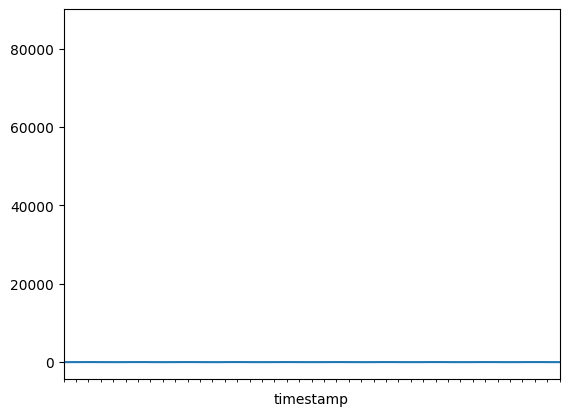

In [10]:
df.set_index("timestamp")["temperature"].resample("M").mean().plot()
df["precipitation"].hist(bins=50)
df["visibility"].plot(kind="box")
